# Extended Kalman Filter

In [1]:
#Importing All Libraries

import pickle  #For Data Handling
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion #For Quaternions and Euler angles

In [2]:
#Load the Data

with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
data['imu_w'].data.shape 


(10918, 3)

In [4]:
# gt: Data object containing ground truth, with the following fields:
# imu_a.data : IMU accelerations in Vehicle Frame
# imu_w.data : IMU angular velocities in Vehicle Frame (Used for quaternion calculations)
# gnss.data : GNSS data
# lidar.data : LIDAR data
# imu_a.t, imu_w.t, gnss.t, lidar.t : Respective timestamps
   
#These are the StampedData objects
gt = data['gt']
imu_a = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

#These are the total number of observations obtained from each sensor in the total timespan of trajectory
IMU_time = 8734
LIDAR_time = 415
GNSS_time = 45

#Use the following actual data and timestamps, obtained from the StampedData object
imu_a.data = imu_a.data[0:IMU_time, :]
imu_a.t = imu_a.t[0:IMU_time]
imu_w.data = imu_w.data[0:IMU_time, :]
imu_w.t = imu_w.t[0:IMU_time]
gnss.data = gnss.data[0:GNSS_time, :]
gnss.t = gnss.t[0:GNSS_time]
lidar.data = lidar.data[0:LIDAR_time, :]
lidar.t = lidar.t[0:LIDAR_time]

In [5]:
gt.p

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.86373210e-07,  3.89518391e-07,  1.81198120e-05],
       [-9.63209914e-07,  7.65627192e-07,  3.62396240e-05],
       ...,
       [ 1.03432021e+02,  1.86314011e+02,  1.22690201e-03],
       [ 1.03486778e+02,  1.86271821e+02,  1.22404099e-03],
       [ 1.03541534e+02,  1.86229615e+02,  1.22165680e-03]])

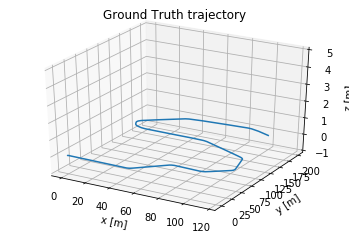

In [6]:
#Run this cell to observe the ground truth tajectory

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [7]:
lidar.data

array([[-1.21543380e+00, -9.50942168e-02, -4.99910491e-01],
       [ 1.51615773e-01, -3.22337937e-01,  1.98545449e-01],
       [-2.59387164e-01, -6.74227693e-01,  5.02131391e-01],
       ...,
       [ 1.16586383e+02,  1.80057683e+02, -3.56678674e+00],
       [ 1.17434949e+02,  1.78260843e+02, -3.15111664e+00],
       [ 1.17803455e+02,  1.77506863e+02, -3.46060333e+00]])

In [8]:
# Transform the LIDAR data from the LIDAR frame to the vehicle (IMU) frame.

#Rotation Matrix
C_li = np.array([
     [ 0.9975 , -0.04742,  0.05235],
     [ 0.04992,  0.99763, -0.04742],
     [-0.04998,  0.04992,  0.9975 ]
])

#Translation Matrix
t_i_li = np.array([0.5, 0.1, 0.5])

lidar.data = (C_li @ lidar.data.T).T + t_i_li

In [9]:
lidar.data.shape

(415, 3)

In [327]:
# 1) Define variances for different sensors
# This will be used to construct the Covariance matrices

var_imu_a = 10
var_imu_w = 10
var_gnss  = 0.7
var_lidar = 37

In [328]:
#The Jacobians 'L' and 'H' and gravity 'g'

g = np.array([0, 0, -9.81])  # gravity
L = np.zeros([9, 6])
L[3:, :] = np.eye(6)  # motion model noise jacobian
H = np.zeros([3, 9])
H[:, :3] = np.eye(3)  # measurement model jacobian

In [329]:
L

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [330]:
#There are total 10 states for a Self Driving Car
# 3 for Positions in each direction (px, py and pz)
# 3 for Velocities in each direction (vx, vy and vz)
# 4 for Quaternions 

#Create an array of zeros for each state
p_est = np.zeros([imu_a.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_a.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_a.data.shape[0], 4])  # orientation estimates as quaternions

p_cov = np.zeros([imu_a.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate

In [331]:
# Create a function to evaluate Measurement update for LIDAR and/or GNSS data
def measurement_update(sensor_var, p_cov_check, z_k, p_check, v_check, q_check):
    # 1) Transform Sensor Variance into Matrix form (Covariance matrix)
    R = np.diag([sensor_var,sensor_var,sensor_var])
    
    # 2) Compute Kalman Gain
    S_temp = np.dot(np.dot(H,p_cov_check), H.T) + R
    K= np.dot(np.dot(p_cov_check, H.T),np.linalg.inv(S_temp)) 

    # 3) Compute innovation and multiply kalman gain
    innovation = np.dot(K, (z_k- p_check)) 

    # 4) Correct predicted state
    p_hat = p_check + innovation[0:3]
    v_hat = v_check + innovation[3:6]
    # Corrected state for Quaternions
    q_hat = Quaternion(euler=innovation[6:]).quat_mult_left(q_check)

    # 5) Compute corrected covariance
    p_cov_hat = np.dot((np.eye(9) - np.dot(K,H)), p_cov_check)
        

    return p_hat, v_hat, q_hat, p_cov_hat


In [332]:

#for k in range(1, imu_a.data.shape[0]):
 #   delta_t = imu_a.t[k]- imu_a.t[k-1]
  #  C_ns = Quaternion(*q_est[k-1]).to_mat()
   #Fk[0:3, 3:6] = np.eye(3)*delta_t
    #Fk[3:6, 3:6] = np.eye(3)
    #Fk[3:6, 6:9] = -(C_ns@skew_symmetric(imu_a.data[k-1].reshape((3,1))))*delta_t
    #v_k = v_est[k-1] + (imu_a.data[k-1]+g)*delta_t
    #p_k = p_est[k-1] + v_k*delta_t + 0.5 * np.dot((imu_a.data[k-1]+g), C_ns)* delta_t**2
    
 


In [333]:
# Motion Model loop to predict using IMU values

for k in range(1, imu_a.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    
    # 1) Calculate "delta_t"
    delta_t = imu_a.t[k]- imu_a.t[k-1]
    
    # 2) Update state with IMU inputs ("p_k, v_k")    
    #C_ns is Euler estimation for Quaternions
    # In position update, use matrix multiplication of (C_ns and imu_a.data[number]) to linearize the model
    # Instead of just using imu_a.data[number] (Use this in velocity)
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    v_k = v_est[k-1] + np.dot(C_ns,(imu_a.data[k-1]+g))*delta_t
    p_k = p_est[k-1] + v_k*delta_t + 0.5 * np.dot((imu_a.data[k-1]+g), C_ns)* delta_t**2
    
    
    # Quaternion States update
    q_k = Quaternion(axis_angle=imu_w.data[k-1]*delta_t).quat_mult_right(q_est[k-1])    

    # Linearize the motion model and compute Jacobians
    Fk = np.eye(9)
    Fk[0:3, 3:6] = np.eye(3)*delta_t
    Fk[3:6, 3:6] = np.eye(3)
    Fk[3:6, 6:9] = -(C_ns@skew_symmetric(imu_a.data[k-1].reshape((3,1))))*delta_t
    
    # 3) Calculate Covariance Matrix (A diagonal matrix consisting of multiple variances)
    A = np.diag([var_imu_a,var_imu_a,var_imu_a,var_imu_w,var_imu_w,var_imu_w])
    Q = np.dot(A, A.T) * (delta_t**2)
    # 4) Propagate uncertainty 
    p_cov_check = np.dot(np.dot(Fk, p_cov[k-1]),Fk.T) + np.dot(np.dot(L, Q), L.T)

    # 5) Check if GNSS and LIDAR measurements are avaiable
    for i in range(len(lidar.t)):
        if imu_a.t[k] == lidar.t[i]:
            z_k = lidar.data[i]
            sensor_var = var_lidar
            p_k, v_k, q_k, p_cov_check = measurement_update(sensor_var, p_cov_check, z_k, p_k, v_k, q_k)
    for i in range(len(gnss.t)):
        if imu_a.t[k] == gnss.t[i]:
            z_k = gnss.data[i]
            sensor_var = var_gnss
            p_k, v_k, q_k, p_cov_check = measurement_update(sensor_var, p_cov_check, z_k, p_k, v_k, q_k)
    
    p_est[k,:] = p_k
    v_est[k,:] = v_k
    q_est[k,:] = q_k
    p_cov[k,:,:] = p_cov_check

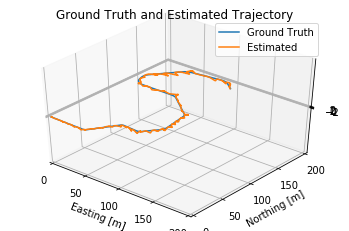

The Mean Squared Error is :7.970200617107077 


In [334]:
#Visualize your trajectory w.r.t. the ground truth trajectory and calculate the mean squared error

est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-100, 100)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=40, azim=-50)
plt.show()

MSE = np.sum(np.square(np.subtract(gt.p, p_est)), axis=None)/IMU_time
print("The Mean Squared Error is :{0} ".format(MSE))